# Scanpy: Quality control

# Get data

In this tutorial, we will be using 3 publicly available dataset downloaded from 10X Genomics repository. They can be downloaded using the following bash commands. Simply create a folder called `data` and then use `curl` to pull the data from the 10X database.


In [6]:
# create a data directory.
!mkdir -p data

# check if file exists before downloading it.
!if [ ! -f data/pbmc_1k_v2_filtered_feature_bc_matrix.h5 ]; then curl -o data/pbmc_1k_v2_filtered_feature_bc_matrix.h5 -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v2/pbmc_1k_v2_filtered_feature_bc_matrix.h5; fi

!if [ ! -f data/pbmc_1k_v3_filtered_feature_bc_matrix.h5 ]; then curl -o data/pbmc_1k_v3_filtered_feature_bc_matrix.h5 -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_filtered_feature_bc_matrix.h5; fi

!if [ ! -f data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5 ]; then curl -o data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5 -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5; fi

With data in place, now we can start loading libraries we will use in this tutorial.


In [7]:
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.17.5 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1


In [8]:
sc.settings.set_figure_params(dpi=80)

We can first load the data individually by reading directly from HDF5 file format (.h5). Note that among those , the dataset p3.1k actually has both gene expression and CITE-seq data, so we will use only the `Gene Expression` here.


In [9]:
data_p3 = sc.read_10x_h5(
    './data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5', gex_only = True)  
# OBS! gex_only to only read gene expression data.
data_p3.var_names_make_unique()

data_v2 = sc.read_10x_h5(
    './data/pbmc_1k_v2_filtered_feature_bc_matrix.h5')
data_v2.var_names_make_unique()

data_v3 = sc.read_10x_h5(
    './data/pbmc_1k_v3_filtered_feature_bc_matrix.h5')
data_v3.var_names_make_unique()


reading ./data/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading ./data/pbmc_1k_v2_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading ./data/pbmc_1k_v3_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


# Create one merged object


In [10]:
# first add in batch info in metadata
data_v2.obs['lib_prep'] = 'v2'
data_v3.obs['lib_prep'] = 'v3'
data_p3.obs['lib_prep'] = 'p3'


# merge into one object
adata = data_v2.concatenate(data_v3, data_p3)

# and delete individual datasets to save space
del(data_v2)
del(data_v3)
del(data_p3)


Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


 You can print a summary of the datasets in the Scanpy object, or a summary of the whole object.


In [11]:
print(adata.obs['lib_prep'].value_counts())

adata

v3    1222
v2     996
p3     713
Name: lib_prep, dtype: int64


AnnData object with n_obs × n_vars = 2931 × 33538 
    obs: 'batch', 'lib_prep'
    var: 'gene_ids', 'feature_types', 'genome'

# Calculate QC

Having the data in a suitable format, we can start calculating some quality metrics. We can for example calculate the percentage of mitocondrial and ribosomal genes per cell and add to the metadata. This will be helpfull to visualize them across different metadata parameteres (i.e. datasetID and chemistry version). There are several ways of doing this, and here manually calculate the proportion of mitochondrial reads and add to the metadata table.

Citing from "Simple Single Cell" workflows (Lun, McCarthy & Marioni, 2017): "High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane."

 First, let Scanpy calculate some general qc-stats for genes and cells with the function `sc.pp.calculate_qc_metrics`, similar to `calculateQCmetrics` in Scater.


In [12]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

# we now have many additional data types in the obs slot:
adata

AnnData object with n_obs × n_vars = 2931 × 33538 
    obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

 Now you can see that we have additional data in the scanpy `obs` slot.


In [13]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

print(sum(mito_genes))

13


In the same manner we will calculate the proportion gene expression that comes from ribosomal proteins.


In [14]:
# Also calculate percent malat1
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1



104


 Now you can see that we have additional data in the scanpy `obs` slot.


In [15]:
adata

AnnData object with n_obs × n_vars = 2931 × 33538 
    obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

# Plot QC

Now we can plot some of the QC-features as violin plots.


... storing 'lib_prep' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


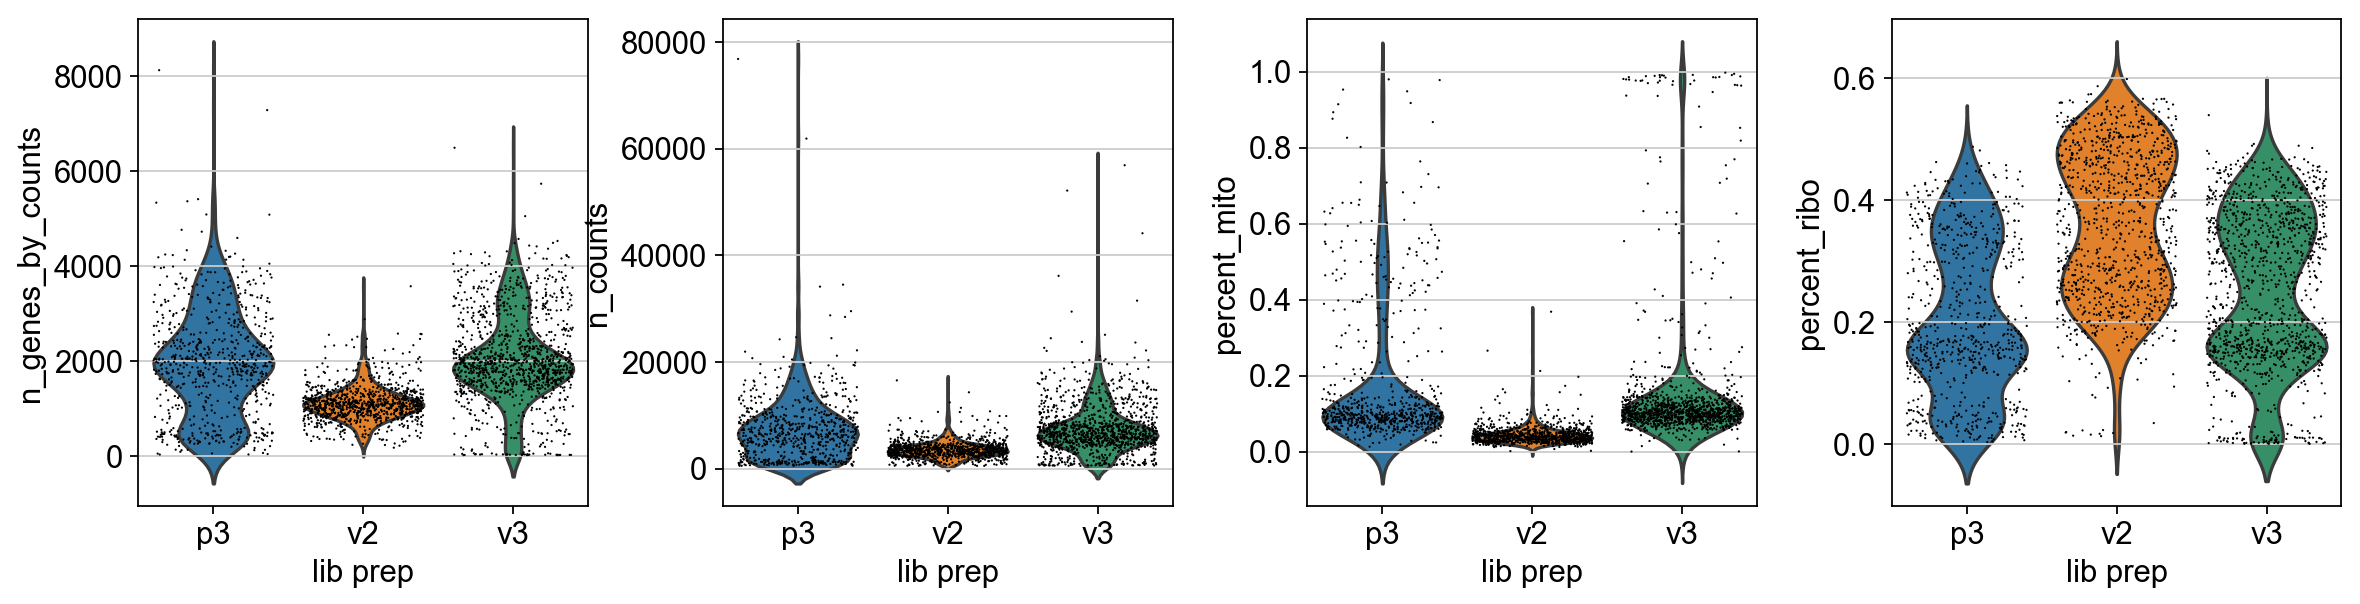

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'lib_prep')

As you can see, the v2 chemistry gives lower gene detection, but higher detection of ribosomal proteins. As the ribosomal proteins are highly expressed they will make up a larger proportion of the transcriptional landscape when fewer of the lowly expressed genes are detected. And we can plot the different QC-measures as scatter plots.


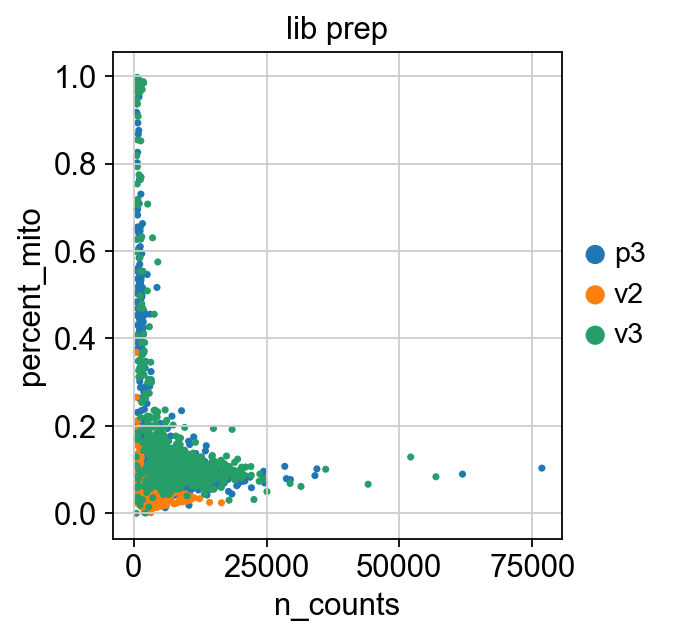

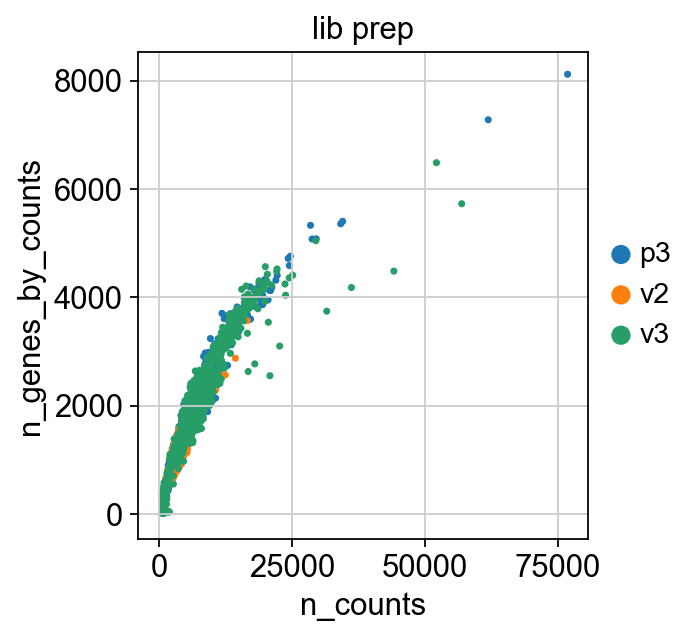

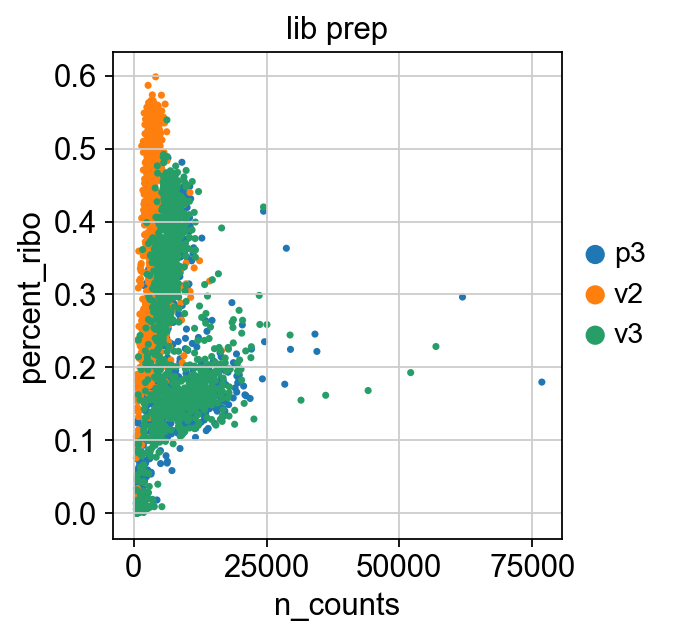

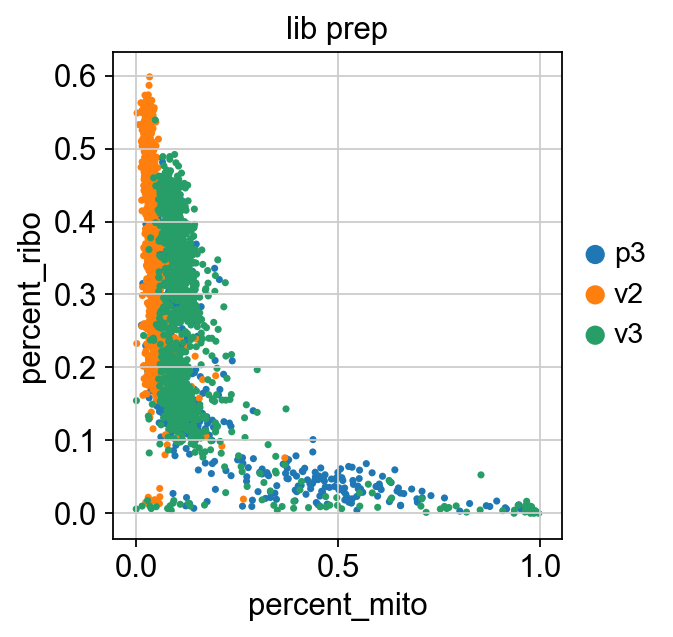

In [17]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color="lib_prep")
sc.pl.scatter(adata, x='n_counts', y='n_genes_by_counts', color="lib_prep")
sc.pl.scatter(adata, x='n_counts', y='percent_ribo', color="lib_prep")
sc.pl.scatter(adata, x='percent_mito', y='percent_ribo', color="lib_prep")

# Filtering

A standard approach is to filter cells with low amount of reads as well as genes that are present in at least a certain amount of cells. Here we will only consider cells with at least 200 detected genes and genes need to be expressed in at least 3 cells. Please note that those values are highly dependent on the library preparation method used.


In [18]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 62 cells that haveless than 200 genes expressed
filtered out 16758 genes that are detectedin less than 3 cells
2869 16780


 Extremely high number of detected genes could indicate doublets. However, depending on the cell type composition in your sample, you may have cells with higher number of genes (and also higher counts) from one cell type. <br>In these datasets, there is also a clear difference between the v2 vs v3 10x chemistry with regards to gene detection, so it may not be fair to apply the same cutoffs to all of them. Also, in the protein assay data there is a lot of cells with few detected genes giving a bimodal distribution. This type of distribution is not seen in the other 2 datasets. Considering that they are all PBMC datasets it makes sense to regard this distribution as low quality libraries. Filter the cells with high gene detection (putative doublets) with cutoffs 4100 for v3 chemistry and 2000 for v2. <br>Here, we will filter the cells with low gene detection (low quality libraries) with less than 1000 genes for v2 and < 500 for v2.


In [19]:
# filter for gene detection for v2
keep_v2 = (adata.obs['n_genes_by_counts'] < 2000) & (adata.obs['n_genes_by_counts'] > 500) & (adata.obs['lib_prep'] == 'v2')
print(sum(keep_v2))

# filter for gene detection for v3
keep_v3 = (adata.obs['n_genes_by_counts'] < 4100) & (adata.obs['n_genes_by_counts'] > 1000) & (adata.obs['lib_prep'] != 'v2')
print(sum(keep_v3))

# keep both sets of cells
keep = (keep_v2) | (keep_v3)
print(sum(keep))
adata = adata[keep, :]

print("Remaining cells %d"%adata.n_obs)

933
1608
2541
Remaining cells 2541


Additionally, we can also see which genes contribute the most to such reads. We can for instance plot the percentage of counts per gene.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


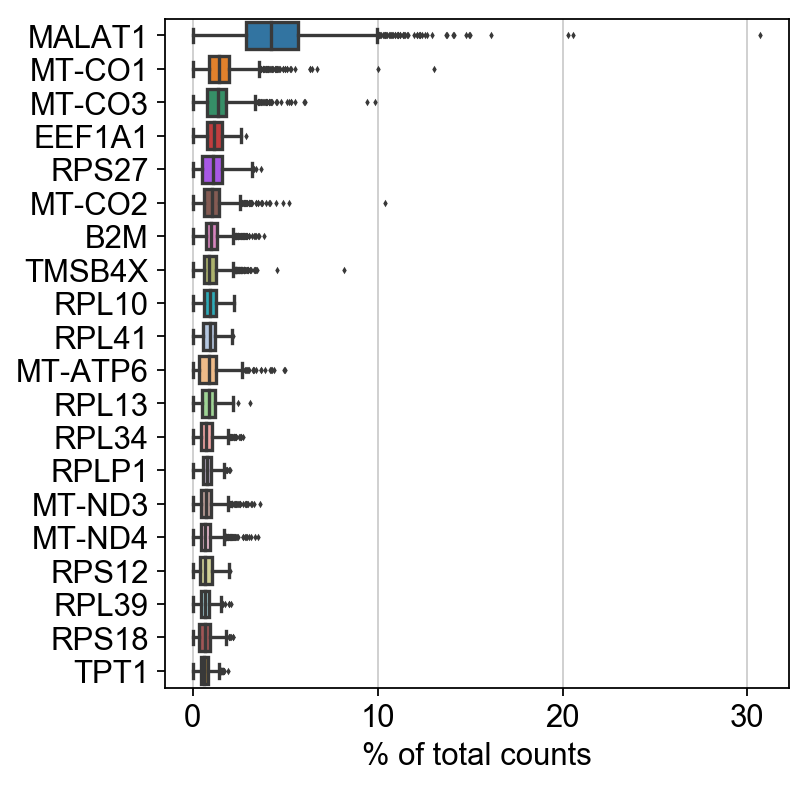

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20)

As you can see, MALAT1 constitutes up to 30% of the UMIs from a single cell and the other top genes are mitochondrial and ribosomal genes. It is quite common that nuclear lincRNAs have correlation with quality and mitochondrial reads, so high detection of MALAT1 may be a technical issue. Let us assemble some information about such genes, which are important for quality control and downstream filtering.

## Mito/Ribo filtering

We also have quite a lot of cells with high proportion of mitochondrial and low proportion ofribosomal reads. It could be wise to remove those cells, if we have enough cells left after filtering. <br>Another option would be to either remove all mitochondrial reads from the dataset and hope that the remaining genes still have enough biological signal. <br>A third option would be to just regress out the `percent_mito` variable during scaling. In this case we had as much as 99.7% mitochondrial reads in some of the cells, so it is quite unlikely that there is much cell type signature left in those. <br>Looking at the plots, make reasonable decisions on where to draw the cutoff. In this case, the bulk of the cells are below 25% mitochondrial reads and that will be used as a cutoff. We will also remove cells with less than 5% ribosomal reads. 


In [21]:
# filter for percent mito
adata = adata[adata.obs['percent_mito'] < 0.25, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['percent_ribo'] > 0.05, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 2527


As you can see, there is still quite a lot of variation in `percent_mito`, so it will have to be dealt with in the data analysis step. We can also notice that the `percent_ribo` are also highly variable, but that is expected since different cell types have different proportions of ribosomal content, according to their function.

## Plot filtered QC

Lets plot the same QC-stats another time.


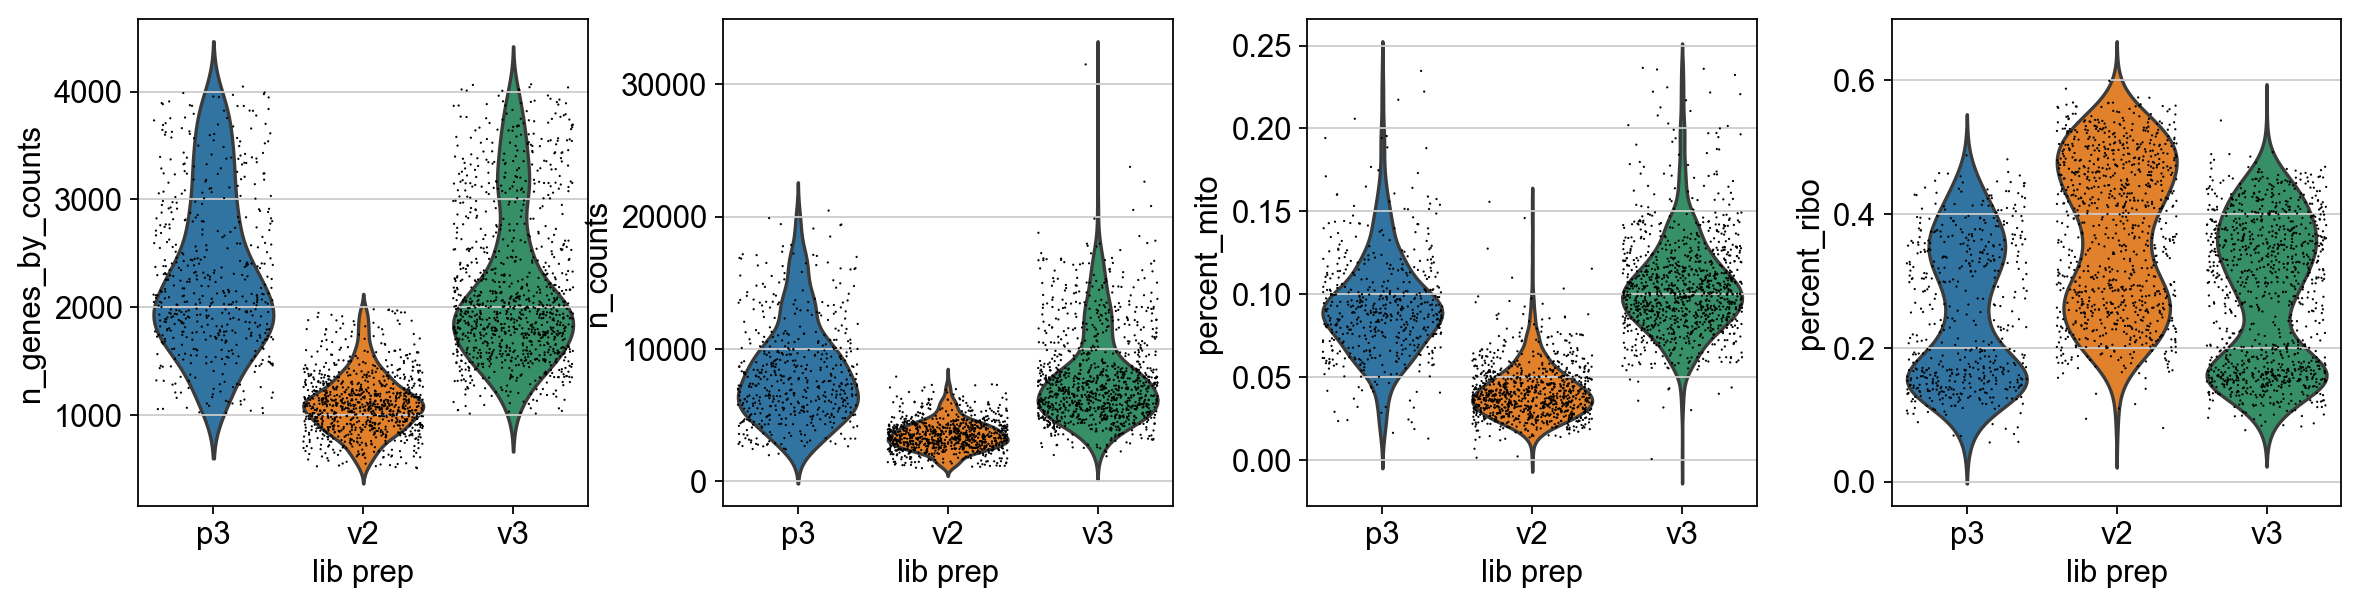

In [22]:
sc.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'lib_prep')

## Filter genes

 As the level of expression of mitochondrial and MALAT1 genes are judged as mainly technical, it can be wise to remove them from the dataset bofore any further analysis. 


In [23]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')

remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

2527 16766


## Save data

Save the filtered dataset to a file for use in later labs.


In [24]:
save_file = 'data/scanpy_qc_filtered_3pbmc.h5ad'
adata.write_h5ad(save_file)

# Calculate cell-cycle scores

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at [RegevLab Github repo](https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt).


In [25]:
!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; then curl -o data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi
    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   556  100   556    0     0   1411      0 --:--:-- --:--:-- --:--:--  1411


In [26]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
90


 Before running cell cycle we have to normalize the data. In the scanpy object, the data slot will be overwritten with the normalized data. So first, save the raw data into the slot `raw`.  <br><br>Then run normalization, logarimize and scale the data. 


In [27]:
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


We here perform cell cycle scoring. The function is actually a wrapper to sc.tl.score_gene_list, which is launched twice, to score separately S and G2M phases. Both sc.tl.score_gene_list and sc.tl.score_cell_cycle_genes are a port from Seurat and are supposed to work in a very similar way. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.


In [28]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


We can now plot a violin plot for the cell cycle scores as well.


... storing 'phase' as categorical


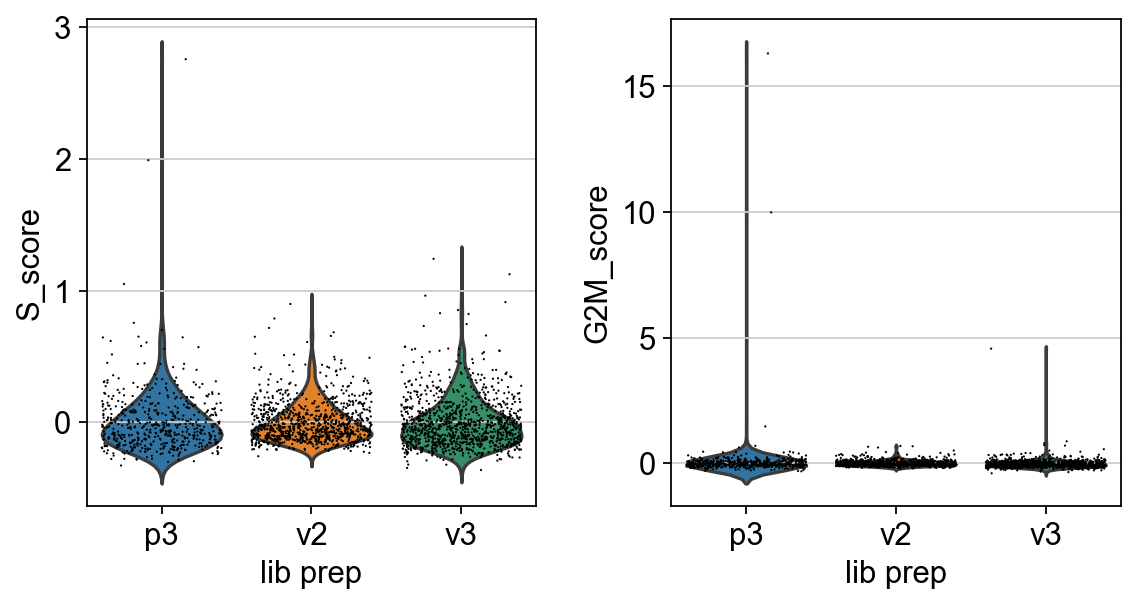

In [29]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'lib_prep')

In this case it looks like we only have a few cycling cells in the datasets.
# Save data 
Finally, lets save the QC-filtered data for further analysis.



In [30]:
adata

AnnData object with n_obs × n_vars = 2527 × 16766 
    obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'lib_prep_colors'